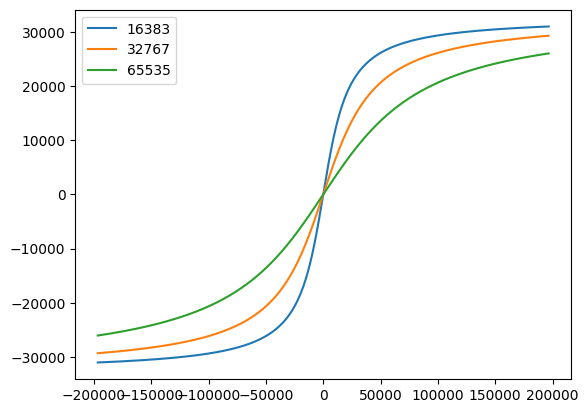

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x=np.arange(-196602, 196602)
# plt.ylim(-1, 1)
arctan=np.arctan(x/16383)*2*32767/np.pi
arctan2=np.arctan(x/32767)*2*32767/np.pi
arctan4=np.arctan(x/65535)*2*32767/np.pi
fuck, = plt.plot(x,arctan, label='16383')
off, = plt.plot(x,arctan2, label='32767')
bastard, = plt.plot(x,arctan4, label='65535')
plt.legend(handles=[fuck, off, bastard])
# plt.plot(x,x)

plt.show()


In [1]:
%load_ext Cython

In [2]:
%%cython -a

import cython
import numpy
cimport numpy
from cython.parallel import prange
from libc.math cimport atan, pi
from libc.stdlib cimport malloc, free
from libc.string cimport memset


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def mix_sounds(list playingsounds, int frame_count, numpy.ndarray output):
    cdef short* output_data = <short *> (output.data)
    cdef numpy.ndarray l, r, env
    cdef float* l_data
    cdef float* r_data
    cdef float* env_data
    cdef double *buffer = <double *> malloc(frame_count * 2 * sizeof(double))

    if not buffer:
        raise MemoryError()

    memset(buffer, 0, frame_count * 2 * sizeof(double));

    cdef double FACTORA = 16383
    cdef double FACTORB = 65535/pi
    cdef float velocity_gain
    cdef Py_ssize_t i

    try:
        for s in playingsounds:
            l, r, env = s.next_block(frame_count)

            l_data = <float *> (l.data)
            r_data = <float *> (r.data)
            env_data = <float *> (env.data)
            velocity_gain = <float> s.velocity_gain

            for i in range(frame_count):
                buffer[i*2] += l_data[i] * env_data[i] * velocity_gain
                buffer[i*2+1] += r_data[i] * env_data[i] * velocity_gain

        for i in range(frame_count * 2):
            output_data[i] = <short> (atan(buffer[i]/FACTORA) * FACTORB)
    finally:
        free(buffer)
